<a href="https://colab.research.google.com/github/hspark1212/MLFF_tutorial/blob/main/mace_finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📘 MACE Tutorial for Group Research Day 2024

Welcome to the MACE Tutorial for Group Research Day 2024! 🌟 This tutorial will guide you through the process of fine-tuning MACE on custom datset.
The foundation model, `MACE-MP` will be working with us, was initially trained on the Materials Project Trajectory (MPTraj) dataset.

This tutorial is divided into the following sections:

**1. Installation**: Set up your environment with the necessary tools and packages.

**2. Exploring MACE**: Learn about how to get energy and force predictions from MACE-MP.

**3. Making a Dataset**: Prepare your dataset for finetuning MACE-MP

**4. Training**: Fine-tune MACE-MP on your custom dataset.

**5. Evaluation**: Evaluate the performance of your fine-tuned MACE model.

**6. Application** - Molecular Dynamics (MD) Simulation: Put your new MACE model into action with a simple MD simulation of copper.

So let's dive in and get started! 🚀

# 0. Installation

First, let’s get your environment ready by installing the necessary packages.

> Our tutorial uses `mace-torch==0.3.6` and MACE is continuously being updated. Please check the latest version of MACE on the [MACE GitHub page](https://github.com/ACEsuit/mace)

In [ ]:
! pip install -q mace-torch==0.3.6
! pip install -q seaborn

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.6/115.6 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 387.7/387.7 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 448.8/448.8 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.6/890.6 kB 10.7 MB/s eta 0:00:00


We’ll also import some libraries for this tutorial.

In [ ]:
from collections import defaultdict
from pprint import pprint

import numpy as np
import pandas as pd

from IPython.display import HTML, display
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import seaborn as sns

from ase import Atoms
from ase import units
from ase.io import read, write
from ase.build import bulk
from ase.visualize import view
from ase.visualize.plot import plot_atoms
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.langevin import Langevin

from mace.calculators import mace_mp

plt.rcParams["font.size"] = 15
sns.set_style("whitegrid")

/usr/local/lib/python3.10/dist-packages/e3nn/o3/_wigner.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.d

# 1. Exploring MACE

Now that we have MACE installed, let's get a better understanding of what it can do. In this section, we'll explore an example of MACE in action, where we model the interaction between copper atoms at varying distances.

## Creating Copper Diatomic Molecules at Various Distances

We will create a series of copper diatomic molecules (Cu2) with different interatomic distances ranging from 0.6 Å to 5.0 Å.

In [ ]:
distances = np.arange(0.6, 5.1, 0.1)
atoms_list = []
for dist in distances:
    atoms = Atoms(
        "Cu2", positions=[[0, 0, 0], [0, 0, dist]], cell=[20, 20, 20], pbc=True
    )
    atoms.info["dist"] = dist
    atoms_list.append(atoms)

## Visualizing the Copper Diatomic Molecules

To visualize these copper atoms, we use matplotlib to create an animation that shows how the atomic configuration changes as the distance between the atoms varies.


In [ ]:
fig, ax = plt.subplots()

def update(frame):
    ax.clear()
    ax.set_axis_off()
    atoms = atoms_list[frame]
    plot_atoms(atoms, ax=ax, show_unit_cell=2, rotation=("90x,0y,0z"))
    plt.title(f"{atoms.info['dist']:.2f} Å")
    return ax


ani = FuncAnimation(fig, func=update, frames=len(atoms_list), repeat=False)
display(HTML(ani.to_jshtml()))
plt.close(fig)

## Loading MACE models with ASE Calculator

We are going to use two different MACE models to calculate the potential energy and forces for each configuration of copper atoms:

*   `MACE-MP`: This model was trained on the MPTraj dataset but may struggle to accurately predict energies when atoms are very close together due to high repulsive forces.

*   `MACE-MP-0b`: This model incorporates a ZBL (Ziegler-Biersack-Littmark) potential with `MACE-MP`, which is better suited for handling high-repulsion situations when atoms are extremely close together.

In [ ]:
mace_mp_calc = mace_mp(
    model="medium",
    device="cpu",
)

mace_mp_0b_calc = mace_mp(
    model="https://github.com/ACEsuit/mace-mp/releases/download/mace_mp_0b/mace_agnesi_medium.model",
    device="cpu",
)

Cached MACE model to /root/.cache/mace/5yyxdm76
Using Materials Project MACE for MACECalculator with /root/.cache/mace/5yyxdm76
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.


/usr/local/lib/python3.10/dist-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_path, map_location=device)


Default dtype float32 does not match model dtype float64, converting models to float32.
Cached MACE model to /root/.cache/mace/mace_agnesi_mediummodel
Using Materials Project MACE for MACECalculator with /root/.cache/mace/mace_agnesi_mediummodel
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.


/usr/local/lib/python3.10/dist-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_path, map_location=device)


Default dtype float32 does not match model dtype float64, converting models to float32.


In [ ]:
# Check it out other parameters
help(mace_mp)

Help on function mace_mp in module mace.calculators.foundations_models:

mace_mp(model: Union[str, pathlib.Path] = None, device: str = '', default_dtype: str = 'float32', dispersion: bool = False, damping: str = 'bj', dispersion_xc: str = 'pbe', dispersion_cutoff: float = 21.167088422553647, **kwargs) -> mace.calculators.mace.MACECalculator
    Constructs a MACECalculator with a pretrained model based on the Materials Project (89 elements).
    The model is released under the MIT license. See https://github.com/ACEsuit/mace-mp for all models.
    Note:
        If you are using this function, please cite the relevant paper for the Materials Project,
        any paper associated with the MACE model, and also the following:
        - MACE-MP by Ilyes Batatia, Philipp Benner, Yuan Chiang, Alin M. Elena,
            Dávid P. Kovács, Janosh Riebesell, et al., 2023, arXiv:2401.00096
        - MACE-Universal by Yuan Chiang, 2023, Hugging Face, Revision e5ebd9b,
            DOI: 10.57967/hf/120

## Calculating and Collecting Energies and Forces

We calculate the energies and forces for each configuration using both models and collect the data.

In [ ]:
collections = defaultdict(list)
for i, atoms in enumerate(atoms_list):
    # Calculate the energy and forces from MACE-MP
    e_mace_mp = mace_mp_calc.get_potential_energy(atoms)
    f_mace_mp = mace_mp_calc.get_forces(atoms)

    # Calculate the energy and forces from MACE-MP-0b
    e_mace_mp_0b = mace_mp_0b_calc.get_potential_energy(atoms)
    f_mace_mp_0b = mace_mp_0b_calc.get_forces(atoms)

    # Collect the data
    dist = distances[i]
    collections["dist"].append(dist)
    collections["atoms"].append(atoms)
    collections["e_mace_mp"].append(e_mace_mp)
    collections["f_mace_mp"].append(f_mace_mp)
    collections["e_mace_mp_0b"].append(e_mace_mp_0b)
    collections["f_mace_mp_0b"].append(f_mace_mp_0b)
df = pd.DataFrame(collections)

In [ ]:
df.head()

,dist,atoms,e_mace_mp,f_mace_mp,e_mace_mp_0b,f_mace_mp_0b
0,0.6,"(Atom('Cu', [0.0, 0.0, 0.0], index=0), Atom('C...",13.075227,"[[0.0, 0.0, 138.65805], [0.0, 0.0, -138.65805]]",53.330116,"[[0.0, 0.0, -366.08545], [0.0, 0.0, 366.08545]]"
1,0.7,"(Atom('Cu', [0.0, 0.0, 0.0], index=0), Atom('C...",20.323231,"[[0.0, 0.0, 127.26222], [0.0, 0.0, -127.26222]]",29.749208,"[[0.0, 0.0, -140.28374], [0.0, 0.0, 140.28374]]"
2,0.8,"(Atom('Cu', [0.0, 0.0, 0.0], index=0), Atom('C...",25.741703,"[[0.0, 0.0, -71.73869], [0.0, 0.0, 71.73869]]",20.730017,"[[0.0, 0.0, -53.96564], [0.0, 0.0, 53.96564]]"
3,0.9,"(Atom('Cu', [0.0, 0.0, 0.0], index=0), Atom('C...",18.688644,"[[0.0, 0.0, -49.647823], [0.0, 0.0, 49.647823]]",17.065266,"[[0.0, 0.0, -26.457005], [0.0, 0.0, 26.457005]]"
4,1.0,"(Atom('Cu', [0.0, 0.0, 0.0], index=0), Atom('C...",13.600991,"[[0.0, 0.0, -49.058624], [0.0, 0.0, 49.058624]]",14.613461,"[[0.0, 0.0, -24.80981], [0.0, 0.0, 24.80981]]"


## Plotting diatomic energy

We plot the potential energy as a function of the interatomic distance for both models.

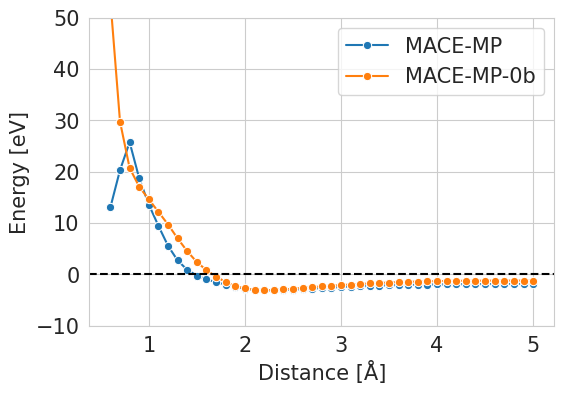

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sns.lineplot(data=df, x="dist", y="e_mace_mp", label="MACE-MP", marker="o", ax=ax)
sns.lineplot(data=df, x="dist", y="e_mace_mp_0b", label="MACE-MP-0b", marker="o", ax=ax)
ax.set_xlabel("Distance [Å]")
ax.set_ylabel("Energy [eV]")
ax.set_ylim(-10, 50)
ax.axhline(0, color="black", linestyle="--")
plt.show()

# 2. Making a Dataset

In this section, we'll prepare your dataset for fine-tuning the MACE-MP model.

## Preparing the Dataset with Reference Energies and Forces
We will use the energies and forces from the `MACE-MP-0b` model as our reference data for fine-tuning.

When preparing the dataset for training MACE, it is essential to store the energy on `atoms.info` and the forces on `atoms.arrays`.

>Note: From ASE version 3.23.0, storing energy information under `atoms.info["energy"]` will be omitted during the reading process using `ase.io.read`. Therefore, it is necessary to use an alternative label. The MACE recommends using `atoms.info["REF_energy"]` to avoid these issues.

In [ ]:
dataset = []
for i, row in df.iterrows():
    atoms = row["atoms"].copy()
    atoms.info["dist"] = row["dist"]
    atoms.info["REF_energy"] = row["e_mace_mp_0b"]
    atoms.arrays["REF_forces"] = row["f_mace_mp_0b"]
    dataset.append(atoms)

## Saving the Dataset
We save the dataset into training, validation, and test files.

In [ ]:
write("train.xyz", dataset)
write("valid.xyz", dataset)
write("test.xyz", dataset)

## Loading and Inspecting the Dataset
We read the dataset back into memory and inspect it.

In [ ]:
train = read("train.xyz", index=":")
valid = read("valid.xyz", index=":")
test = read("test.xyz", index=":")
len(train), len(valid), len(test)

(45, 45, 45)

Ensure that Atoms objects has `"REF_energy"` and `"REF_forces"` attributes after reading the xyz file.

In [ ]:
pprint(train[-1].info)
pprint(train[-1].arrays)
view(train[-1], viewer="x3d")

{'REF_energy': -1.2015119791030884, 'dist': 4.999999999999998}
{'REF_forces': array([[ 0.        ,  0.        ,  0.02842999],
       [ 0.        ,  0.        , -0.02842999]]),
 'numbers': array([29, 29]),
 'positions': array([[0., 0., 0.],
       [0., 0., 5.]])}


# 3. Training

Now, we're ready to fine-tune the MACE-MP model on your custom dataset.

## Running the Training Script

We use the mace_run_train command to start the training process.

In [ ]:
! mace_run_train \
    --name="mace_tutorial" \
    --foundation_model="medium" \
    --train_file="train.xyz" \
    --valid_file="valid.xyz" \
    --test_file="test.xyz" \
    --energy_weight=1.0 \
    --forces_weight=1.0 \
    --energy_key="REF_energy" \
    --forces_key="REF_forces" \
    --E0s="foundation" \
    --lr=1e-3 \
    --weight_decay=1e-8 \
    --batch_size=4 \
    --max_num_epochs=10 \
    --ema \
    --default_dtype="float32" \
    --device="cpu" \
    --seed=0


/usr/local/lib/python3.10/dist-packages/e3nn/o3/_wigner.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.d

**Key parameters**

*   --name: Specifies the name of the training run.
*   --foundation_model: Indicates which pre-trained model to start from.
*   --train_file, --valid_file, --test_file: Paths to your datasets.
*   --energy_weight, --forces_weight: Weights for energy and force terms in the loss function.
*   --energy_key, --forces_key: Keys used in the dataset for reference energies and forces.
*   --E0s: Specifies how to handle reference energies (using foundation model's zero-point energies).
*   --lr: Learning rate.
*   --weight_decay: Weight decay for regularization.
*   --batch_size: Number of samples per batch.
*   --max_num_epochs: Maximum number of training epochs.
*   --ema: Use Exponential Moving Average of model parameters.
*   --default_dtype: Sets the default data type for computations.
*   --device: Specifies the device for computation (cpu or cuda).
*   --seed: Seed for random number generators for reproducibility.

In [ ]:
# Check it out other parameters
! mace_run_train -h

/usr/local/lib/python3.10/dist-packages/e3nn/o3/_wigner.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.d

## [TIPs]


1.   **Setting Atomic Numbers**:

If you do not explicitly specify `atomic_number`, the model will only support the atomic numbers present in your fine-tuning dataset. For example, if your fine-tuning data contains only copper, the model will not be able to use any other atomic numbers.
To prevent this limitation, you can explicitly provide a list of all atomic numbers supported by `mace_mp`.

```bash
--atomic_number="[1, 2, ..., 94]"
```

2.   **Setting isolated atom energies**

Isolated atom energies are designed for efficient training the mace model as initial atomic energies. You can manually define these values, as shown below:

```
--E0s={1: 1.304, ... 94: 4.259}
```
When fine-tuning a foundation model, it’s generally recommended to use "foundation" to apply the default settings from the foundation model.
Alternatively, you may use "average" to compute the average isolated atom energies from your training data; however, this approach is more commonly suited to pretraining.





# 4. Evaluation

After training, we evaluate the performance of your fine-tuned MACE model.

## Loading the Fine-Tuned Model

We load the fine-tuned model using the mace_mp function.

In [ ]:
finetuning_calc = mace_mp(model="mace_tutorial.model", device="cpu")

Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.


/usr/local/lib/python3.10/dist-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_path, map_location=device)


## Calculating Energies and Forces on the Test Set

We compute the energies and forces predicted by the fine-tuned model for each configuration in the test set.

In [ ]:
collection = defaultdict(list)
for atoms in test:
    dist = atoms.info["dist"]

    # Calculate the energy and forces from MACE-MP (finetuning)
    e_finetuning = finetuning_calc.get_potential_energy(atoms)
    f_finetuning = finetuning_calc.get_forces(atoms)

    # Collect the data
    collection["dist"].append(dist)
    collection["e_finetuning"].append(e_finetuning)
    collection["f_finetuning"].append(f_finetuning)

# merge with df
df_total = df.copy()
df_finetuning = pd.DataFrame(collection)
df_total = pd.merge(df_total, df_finetuning, on="dist")

## Plotting the Comparison

We plot the energies from the original MACE-MP, MACE-MP-0b, and the fine-tuned model.

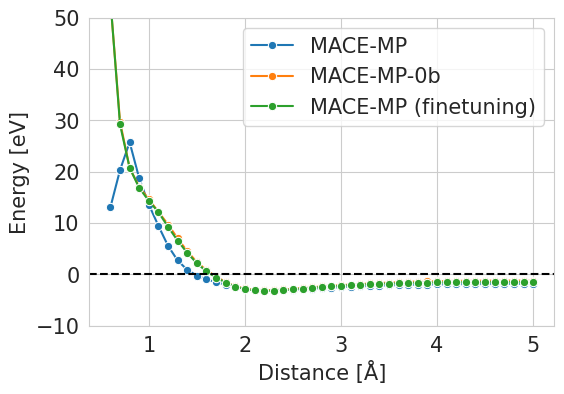

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sns.lineplot(data=df_total, x="dist", y="e_mace_mp", label="MACE-MP", marker="o", ax=ax)
sns.lineplot(
    data=df_total, x="dist", y="e_mace_mp_0b", label="MACE-MP-0b", marker="o", ax=ax
)
sns.lineplot(
    data=df_total,
    x="dist",
    y="e_finetuning",
    label="MACE-MP (finetuning)",
    marker="o",
    ax=ax,
)
ax.set_xlabel("Distance [Å]")
ax.set_ylabel("Energy [eV]")
ax.set_ylim(-10, 50)
ax.axhline(0, color="black", linestyle="--")
plt.show()

The finetuning model now can predict the repusion part well ! 🤗

# 5. Application (MD simulation)

Now that we've fine-tuned our MACE model, let's apply it in a molecular dynamics simulation.

## Creating a Bulk Copper Structure

We start by creating a bulk face-centered cubic (fcc) copper structure.

In [ ]:
atoms = bulk("Cu", "fcc", a=4.6, cubic=True)
view(atoms, viewer="x3d")

# Setting Up the Calculator and MD simulation.

We assign our fine-tuned MACE calculator to the atomic structure.
Then, Set up very simple Langevin thermostat to control the temperature during the simulation.




In [ ]:
# Set up Calculator
atoms.calc = finetuning_calc

# Set up initial velocities
temperature = 300  # K
MaxwellBoltzmannDistribution(atoms, temperature_K=temperature)

# Set up the dynamics
time_step = 1.0  # fs
dyn = Langevin(
    atoms,
    timestep=time_step * units.fs,
    temperature_K=temperature,
    friction=0.01 / units.fs,
    trajectory="Cu_fcc.traj",
    loginterval=10,
)

# Run the dynamics
n_steps = 100
dyn.run(
    n_steps,
)

# Read the trajectory
traj = read("Cu_fcc.traj", index=":")

## Visualizing the Trajectory

After the simulation, we read and visualize the trajectory.

In [ ]:
fig, ax = plt.subplots()

def update(frame):
    ax.clear()
    plot_atoms(traj[frame], ax=ax, show_unit_cell=2)
    ax.set_axis_off()
    plt.title(f"Frame {frame}")
    return ax

ani = FuncAnimation(fig, func=update, frames=len(traj), repeat=False)
display(HTML(ani.to_jshtml()))
plt.close(fig)

# DONE !! 🎉

# Keep in mind that "finetuning does not always lead to good results"

When finetuning a pretrained model with a limited dataset, the model's weights are updated, often leading to increased overfitting. This process introduces two primary issues during finetuning:

## 1. Smoothing (or Softening)

Most data points are more likely to be located in equilibrium regions rather than in repulsion regions. For example, MPTraj data represents geometry optimization trajectories, which can lead to a smoothing issue where even the pretrained model (e.g., MACE-MP) ruggles to accurately predict repulsion forces.

During finetuning, unlike pre-training which uses a diverse and extensive dataset, the data is limited, resulting in an even more severe smoothing effect.

(Check it out the relavalent paper on smoothing. [Overcoming systematic softening in universal machine learning interatomic potentials by finetuning](https://arxiv.org/abs/2405.07105)

## 2. Forgetting

Forgetting occurs when a finetuned model loses its ability to generalize to data outside the finetuning domain. For instance, if the MPTraj dataset contains information on inorganic materials and we fine-tune the model with organic materials, will the fine-tuned model still maintain its performance on inorganic materials? Unfortunately, the answer is often "no." This degradation is known as the "forgetting issue."

To illustrate, consider finetuning `MACE-MP` using a dataset that contains only copper-related data. This finetuning may adversely impact the model’s performance on predicting the interatomic potential of other elements, such as gold (Au) for this case. The following example explores how fine-tuning with a narrowly focused dataset affects (or disrupt) the foundation model.

In [ ]:
! mace_run_train \
    --name="mace_advance_1" \
    --foundation_model="medium" \
    --train_file="train.xyz" \
    --valid_file="valid.xyz" \
    --test_file="test.xyz" \
    --energy_weight=1.0 \
    --forces_weight=1.0 \
    --energy_key="REF_energy" \
    --forces_key="REF_forces" \
    --atomic_numbers="[29, 79]" \
    --E0s="foundation" \
    --lr=1e-2 \
    --weight_decay=1e-8 \
    --batch_size=4 \
    --max_num_epochs=10 \
    --ema \
    --default_dtype="float32" \
    --device="cpu" \
    --seed=0


/usr/local/lib/python3.10/dist-packages/e3nn/o3/_wigner.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.d

In [ ]:
distances = np.arange(0.6, 5.1, 0.1)
atoms_list = []
for dist in distances:
    atoms = Atoms(
        "Au2", positions=[[0, 0, 0], [0, 0, dist]], cell=[20, 20, 20], pbc=True
    )
    atoms.info["dist"] = dist
    atoms_list.append(atoms)

In [ ]:
finetuning_calc = mace_mp(model="mace_advance_1.model", device="cpu")

Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.


/usr/local/lib/python3.10/dist-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_path, map_location=device)


In [ ]:
collections = defaultdict(list)
for i, atoms in enumerate(atoms_list):
    # Calculate the energy and forces from MACE-MP
    e_mace_mp = mace_mp_calc.get_potential_energy(atoms)
    f_mace_mp = mace_mp_calc.get_forces(atoms)

    # Calculate the energy and forces from MACE-MP-0b
    e_mace_mp_0b = mace_mp_0b_calc.get_potential_energy(atoms)
    f_mace_mp_0b = mace_mp_0b_calc.get_forces(atoms)

    # Calculate the energy and forces from MACE-MP (finetuning)
    e_finetuning = finetuning_calc.get_potential_energy(atoms)
    f_finetuning = finetuning_calc.get_forces(atoms)

    # Collect the data
    dist = distances[i]
    collections["dist"].append(dist)
    collections["atoms"].append(atoms)
    collections["e_mace_mp"].append(e_mace_mp)
    collections["f_mace_mp"].append(f_mace_mp)
    collections["e_mace_mp_0b"].append(e_mace_mp_0b)
    collections["f_mace_mp_0b"].append(f_mace_mp_0b)
    collections["e_finetuning"].append(e_finetuning)
    collections["f_finetuning"].append(f_finetuning)
df_advance_1 = pd.DataFrame(collections)

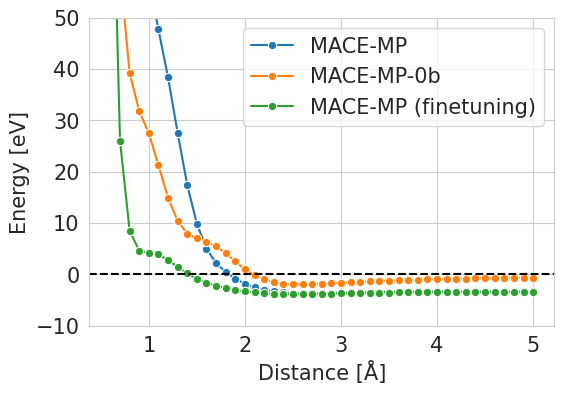

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sns.lineplot(data=df_advance_1, x="dist", y="e_mace_mp", label="MACE-MP", marker="o", ax=ax)
sns.lineplot(
    data=df_advance_1, x="dist", y="e_mace_mp_0b", label="MACE-MP-0b", marker="o", ax=ax
)
sns.lineplot(
    data=df_advance_1,
    x="dist",
    y="e_finetuning",
    label="MACE-MP (finetuning)",
    marker="o",
    ax=ax,
)
ax.set_xlabel("Distance [Å]")
ax.set_ylabel("Energy [eV]")
ax.set_ylim(-10, 50)
ax.axhline(0, color="black", linestyle="--")
plt.show()

## How to Mitigate FineTuning Issues

To address these issues, consider the following strategies (from my experience..):

1. **Lower the Learning Rate**: Reducing the learning rate helps ensure that the changes to the model's weights are subtle, preventing drastic shifts that can lead to overfitting and forgetting.

2. **Minimize Weight Update Steps**: Reducing the number of weight update steps helps preserve the pretrained features. High epochs or step counts lead to significant changes in model weights. So finetune the model similar to **"seasoning lightly"**.

3. **Incorporate Pretraining Data Explicitly**: One way to prevent forgetting is to explicitly add samples from the pre-training dataset during fine-tuning. It appears that MACE repo is developing advanced finetuning techniuqe named `Multihead Replay Fine-Tuning`. You can read more about it in their documentation [here](https://mace-docs.readthedocs.io/en/latest/guide/finetuning.html#multihead-replay-fine-tuning).

4. **Utilize Regularization Methods**:  Implementing regularization techniques, such as tuning weight decay, dropout, gradient clipping, can help control overfitting.